In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from itertools import product
import re

import mp_run
import conf_interval

from os import listdir
from os.path import isfile, join
from sklearn.metrics import mean_squared_error, explained_variance_score

import os

from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from scipy import stats

from multiprocessing import Pool, cpu_count


%load_ext autoreload
%autoreload 2

# regex for number extraction from string
number_pattern =  r'(-?(?:0|[1-9]\d*)(?:\.\d+)?(?:[eE][+-]?\d+)?)'

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':200})

In [2]:
# res_df_list = [
#     pd.read_csv('./yeast_network_v_model.csv', index_col=0),
#     pd.read_csv('./bsubtilis_network_v_model.csv', index_col=0),
#     pd.read_csv('./arabidopsis_network_v_model.csv', index_col=0),
#     pd.read_csv('./mouse_bulk_network_v_model.csv', index_col=0)
# ]

res_df_list = [
    pd.read_csv('../output/network_model/yeast_all_tf_high_var_target.csv.gz', index_col=0, compression='gzip'),
    pd.read_csv('../output/network_model/bsubtilis_all_tf_high_var_target.csv.gz', index_col=0, compression='gzip'),
    pd.read_csv('../output/network_model/arabidopsis_all_tf_high_var_target.csv.gz', index_col=0, compression='gzip'),
    pd.read_csv('../output/network_model/mouse_all_tf_high_var_target.csv.gz', index_col=0, compression='gzip'),
]

species_names = ['Yeast', 'B.subtilis', 'Arabidopsis', 'Mouse']

filtered_df_list = [res_df[res_df['test_std'] > 0.5] for res_df in res_df_list]



In [11]:
filtered_df_list[2].mean()

rf_score                              0.419484
linear_score                          0.378474
gs_rf_score                           0.295774
gs_linear_score                       0.277252
rf_with_linear_top_features_score     0.369254
linear_with_rf_top_features_score     0.305261
rf_rmse                               0.861242
linear_rmse                           0.868097
gs_rf_rmse                            0.966050
gs_linear_rmse                        0.976911
rf_with_linear_top_features_rmse      0.893827
linear_with_rf_top_features_rmse      0.959439
rf_with_top_features_score            0.364122
linear_with_top_features_score        0.316096
rf_with_top_features_rmse             0.908425
linear_with_top_features_rmse         0.937187
rf_top_feature_num                    4.614712
linear_top_feature_num                5.907502
rf_top_features_gs_overlap            1.185725
linear_top_features_gs_overlap        1.316824
rf_linear_top_features_overlap        1.530226
gs_edge_num  

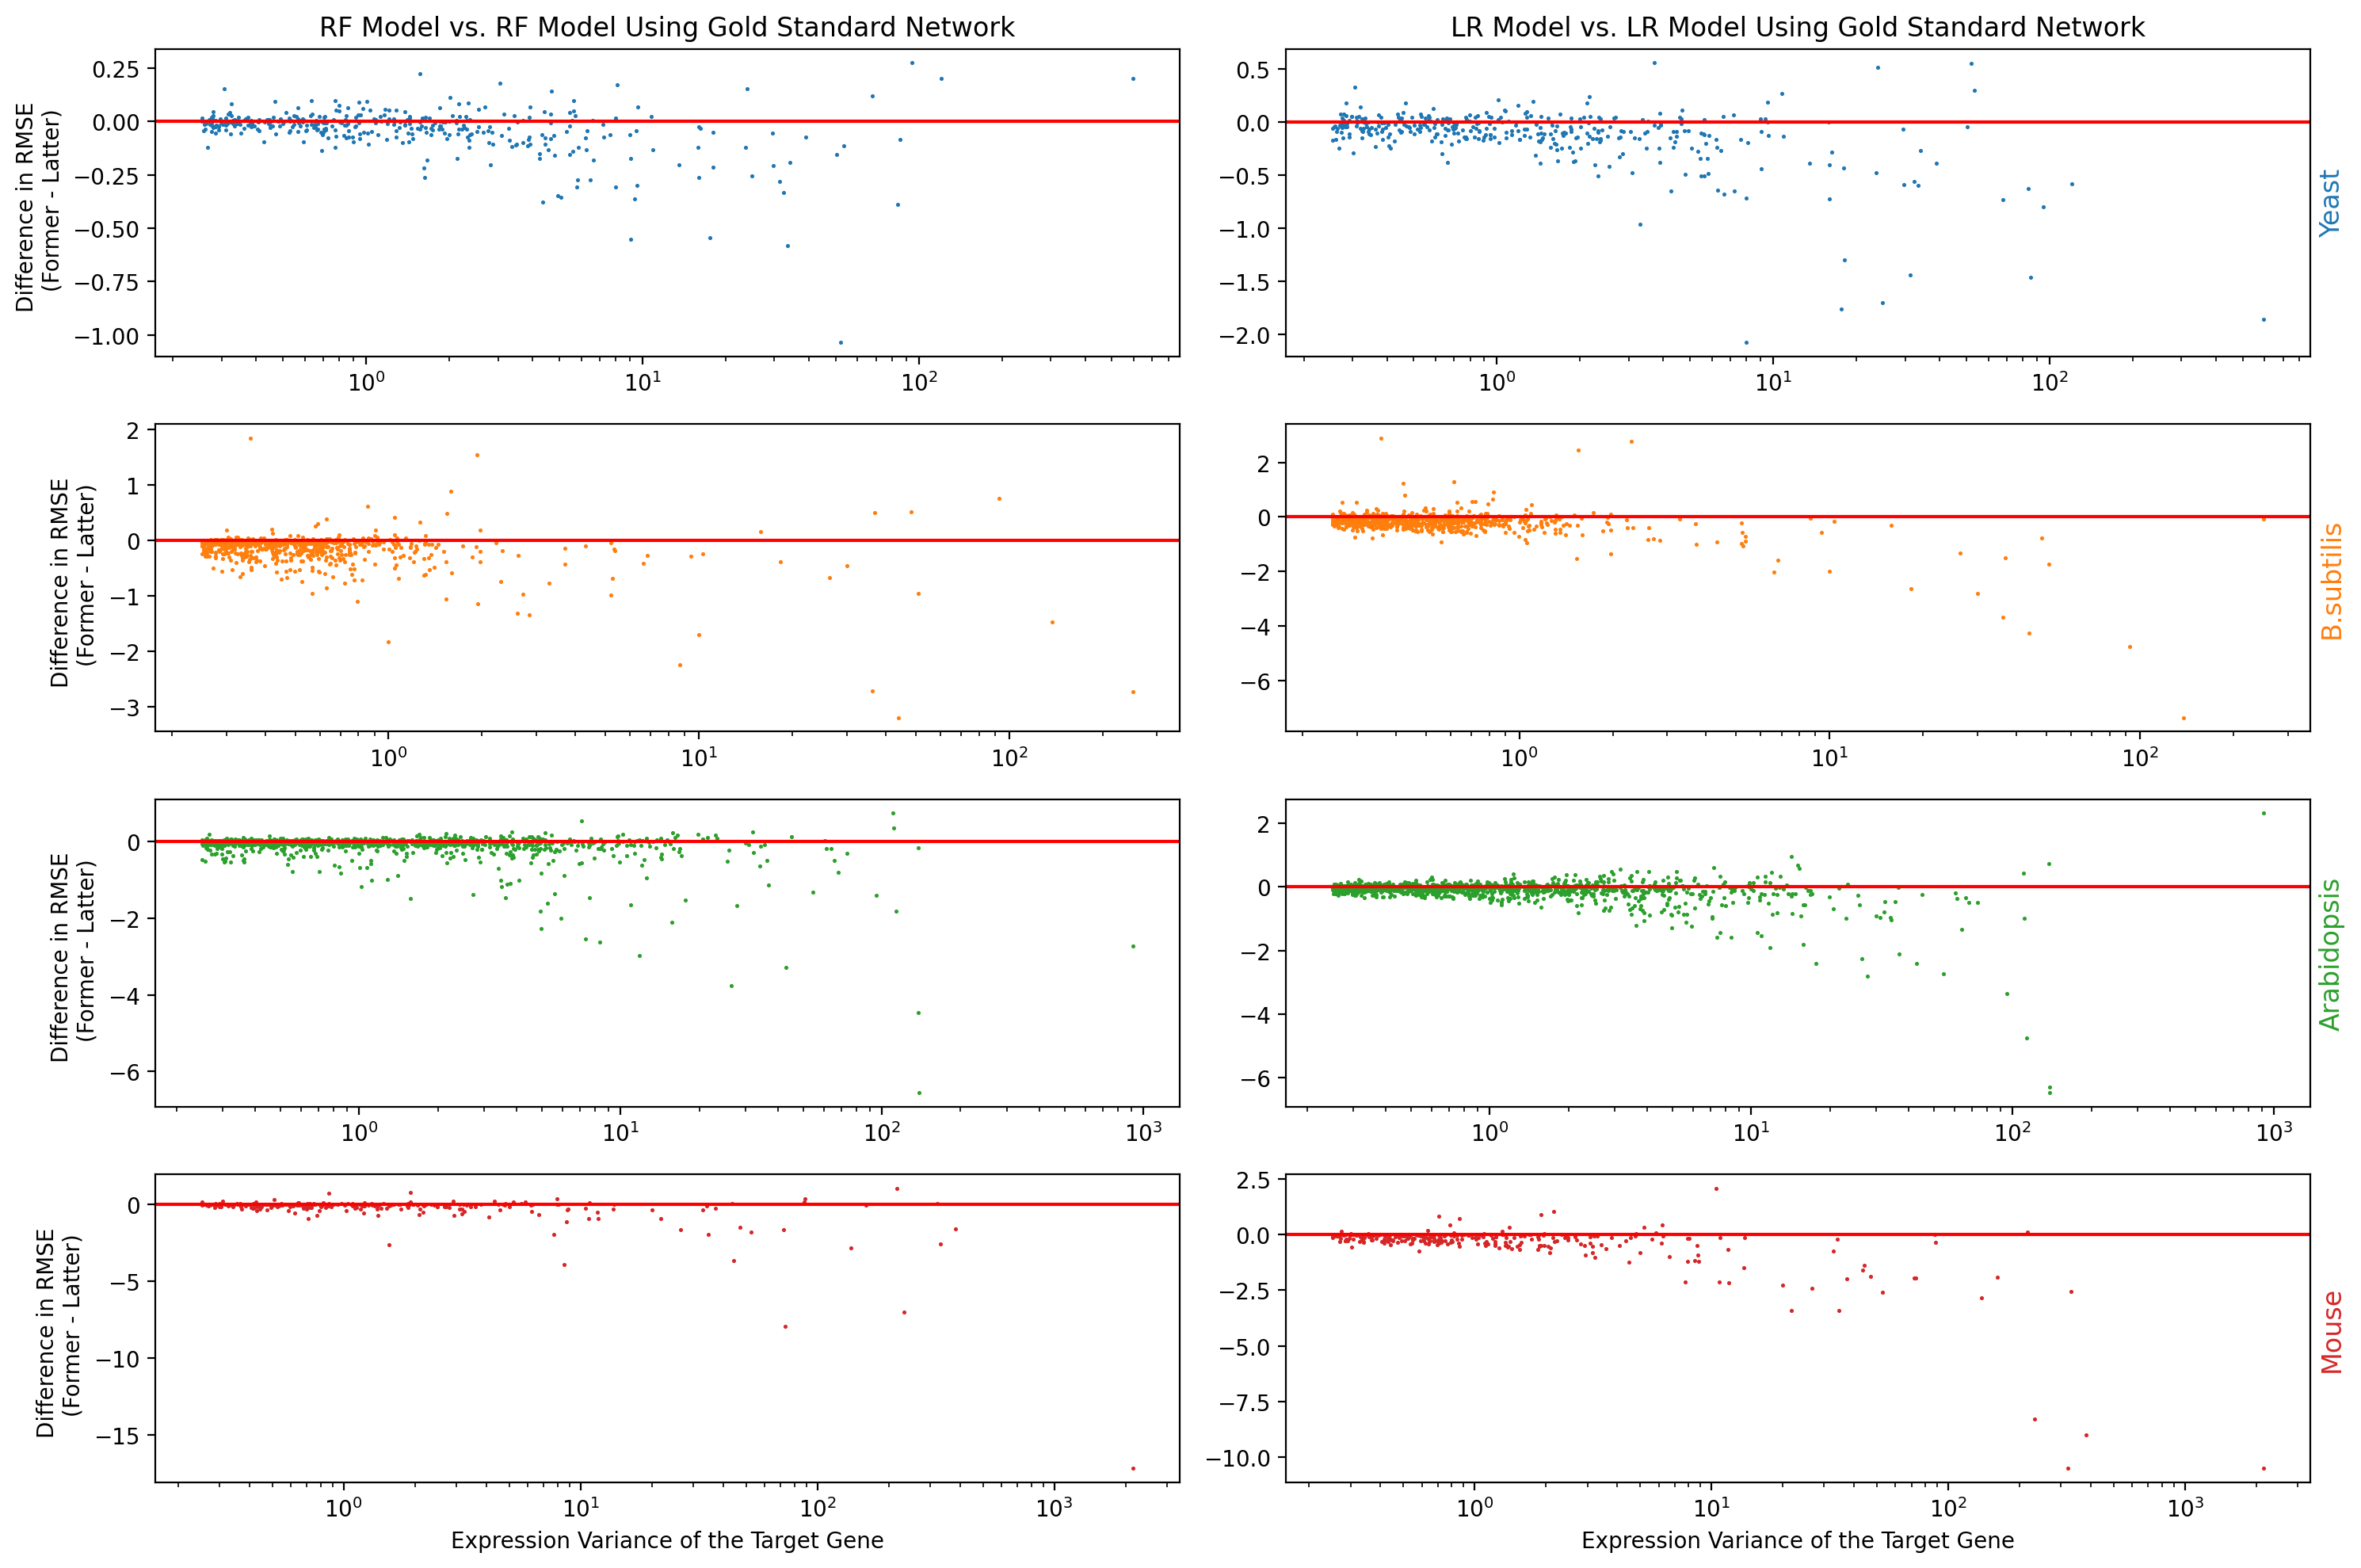

In [3]:
a = 'linear_rmse'
b = 'gs_linear_rmse'
c = 'rf_rmse'
d = 'gs_rf_rmse'

fig, axs = plt.subplots(4, 2, figsize=(15, 10))

for i in range(4):
    df = filtered_df_list[i]
    diff = df[c] - df[d]
    axs[i, 0].scatter(df['test_var'], diff, s=0.7, color=plt.cm.tab10(i))
    # plt.scatter(range(len(diff)),diff, s=0.2)
    axs[i, 0].axhline(y=0, color='r', linestyle='-')
    axs[i, 0].set_xscale('log')
    
    diff = df[a] - df[b]
    axs[i, 1].scatter(df['test_var'], diff, s=0.7, color=plt.cm.tab10(i))
    # plt.scatter(range(len(diff)),diff, s=0.2)
    axs[i, 1].axhline(y=0, color='r', linestyle='-')
    axs[i, 1].set_xscale('log')
    
for i in range(4):
    axs[i, 0].set(ylabel='Difference in RMSE \n (Former - Latter)')
    axs[i, 1].set_ylabel(species_names[i], color=plt.cm.tab10(i), size='large')
    axs[i, 1].yaxis.set_label_position("right")

axs[3, 0].set(xlabel='Expression Variance of the Target Gene')
axs[3, 1].set(xlabel='Expression Variance of the Target Gene')

axs[0, 0].set_title('RF Model vs. RF Model Using Gold Standard Network')
axs[0, 1].set_title('LR Model vs. LR Model Using Gold Standard Network')
fig.tight_layout()
fig.savefig('./plot_output/all_v_gs.pdf', format='pdf', dpi=300)

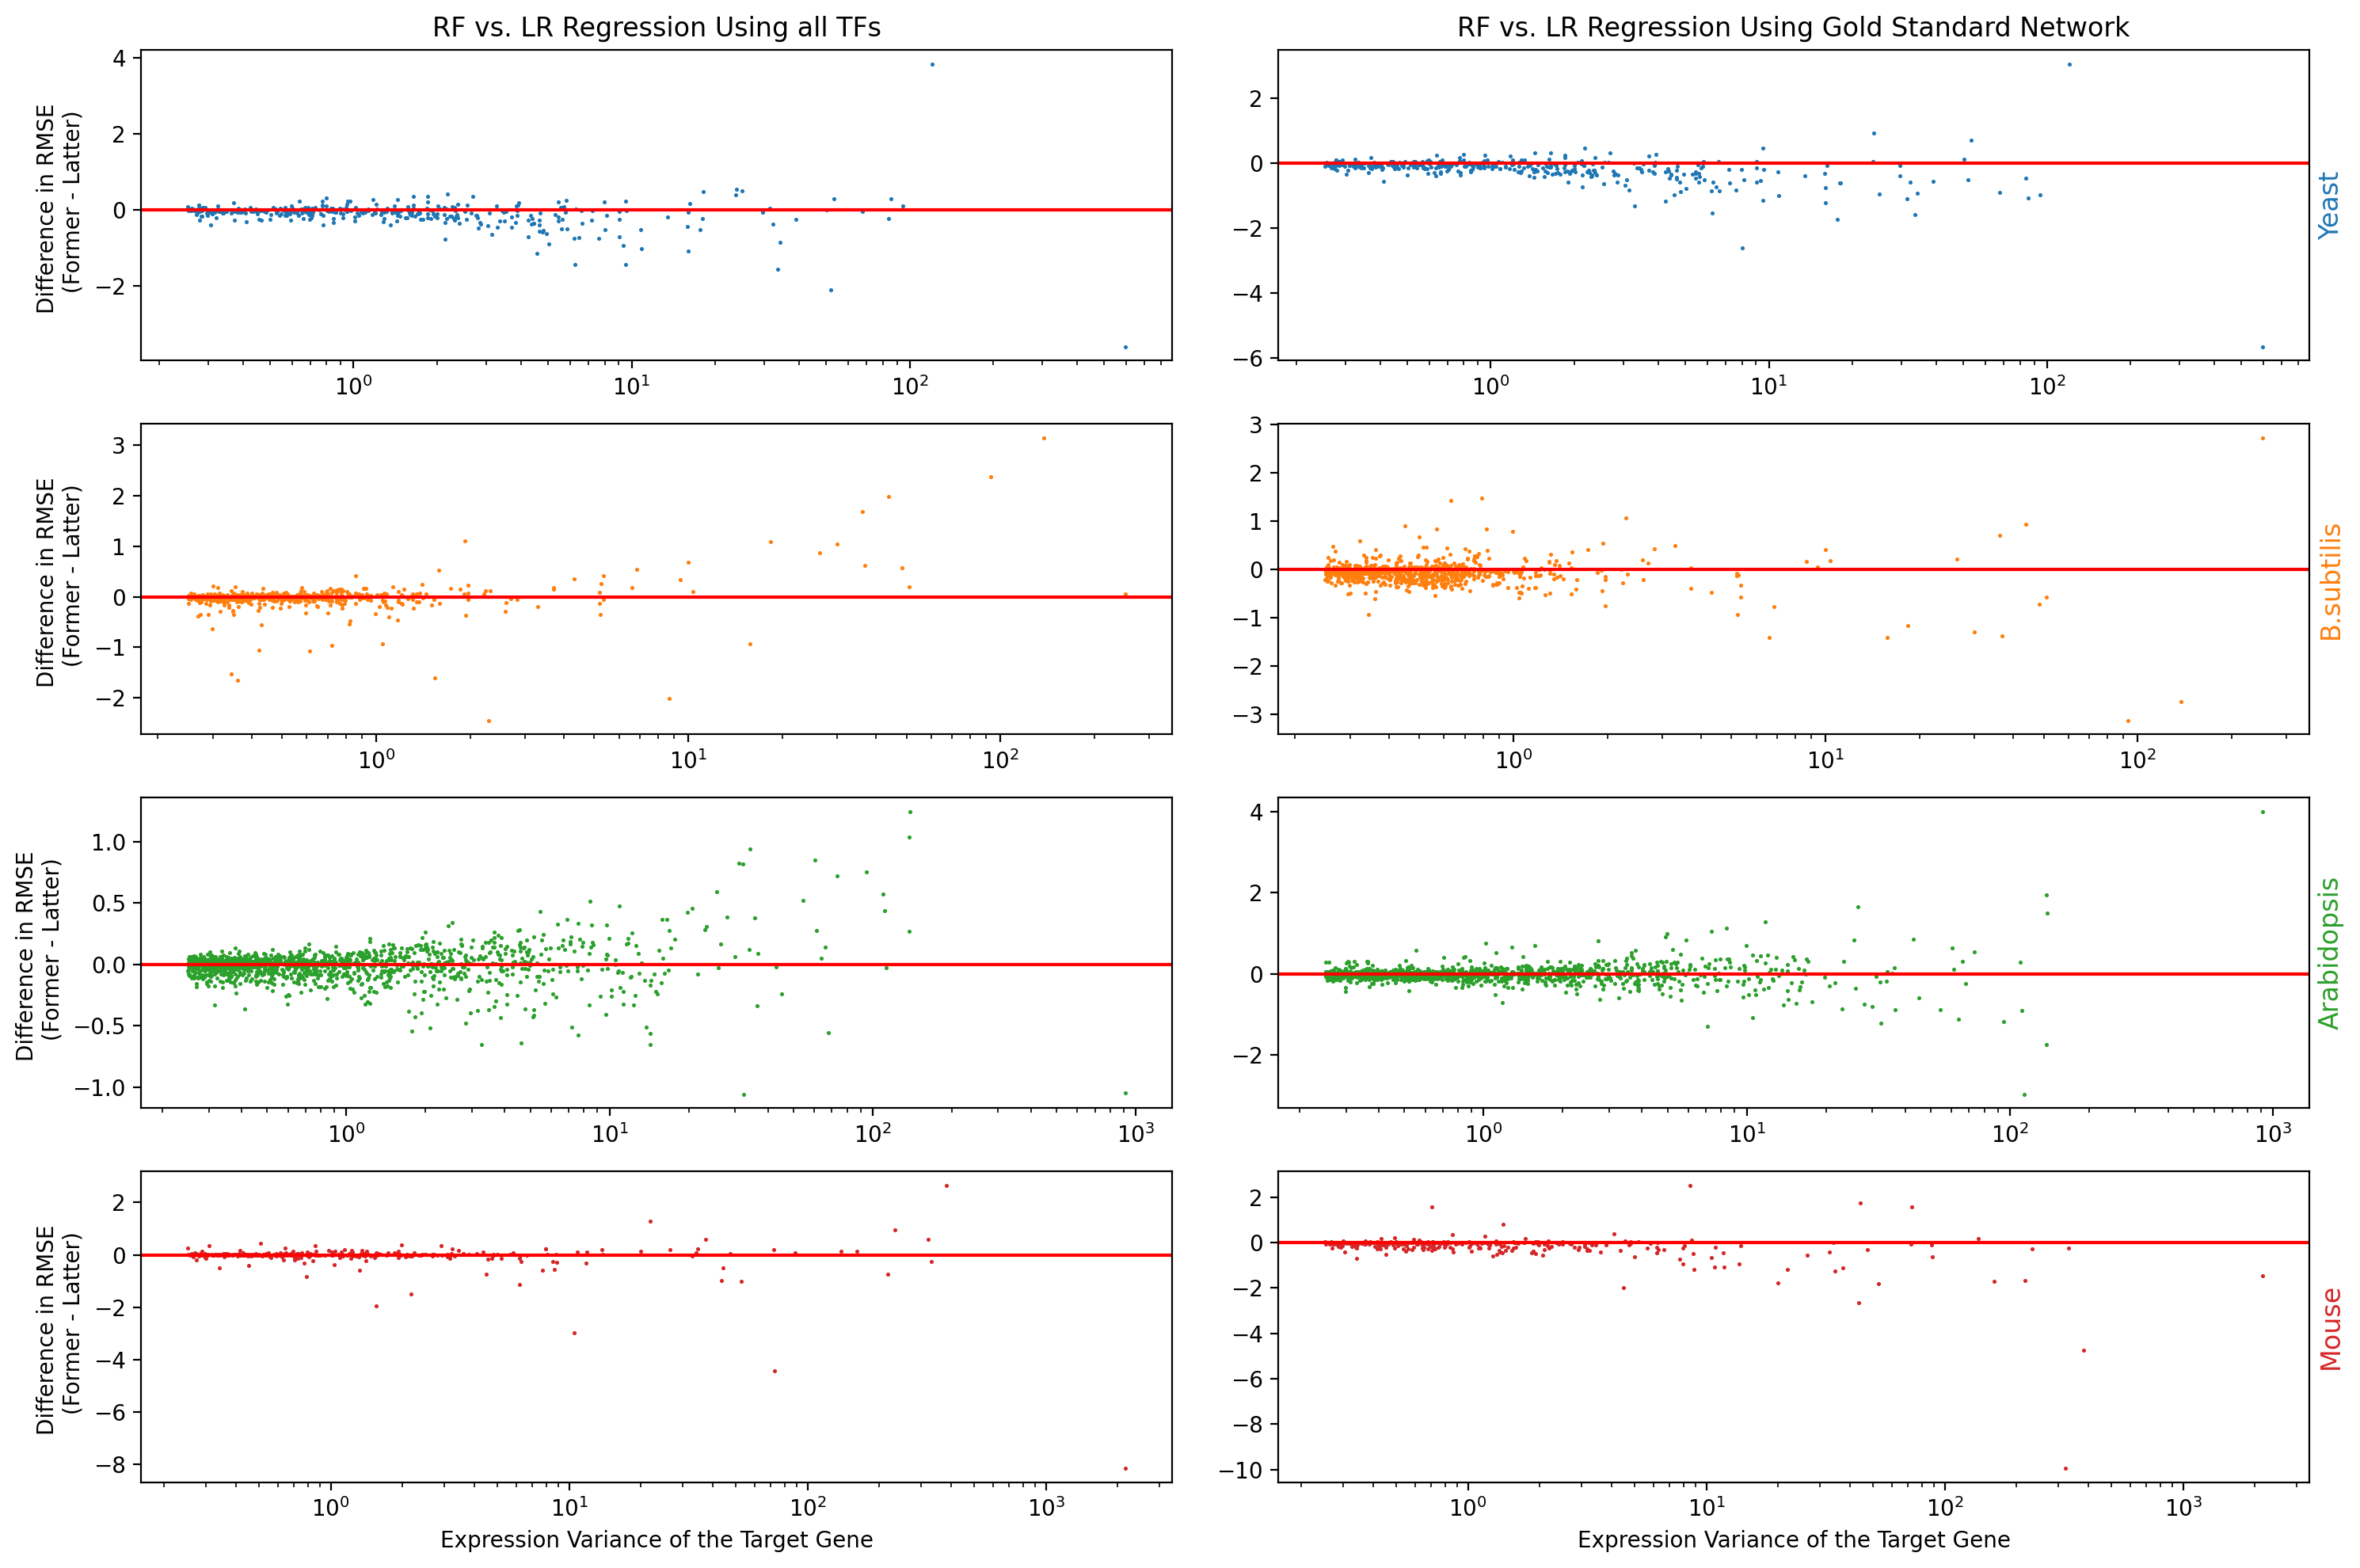

In [4]:
a = 'rf_rmse'
b = 'linear_rmse'
c = 'gs_rf_rmse'
d = 'gs_linear_rmse'

fig, axs = plt.subplots(4, 2, figsize=(15, 10))

for i in range(4):
    df = filtered_df_list[i]
    diff = df[a] - df[b]
    axs[i, 0].scatter(df['test_var'], diff, s=0.7, color=plt.cm.tab10(i))
    # plt.scatter(range(len(diff)),diff, s=0.2)
    axs[i, 0].axhline(y=0, color='r', linestyle='-')
    axs[i, 0].set_xscale('log')
    
    diff = df[c] - df[d]
    axs[i, 1].scatter(df['test_var'], diff, s=0.7, color=plt.cm.tab10(i))
    # plt.scatter(range(len(diff)),diff, s=0.2)
    axs[i, 1].axhline(y=0, color='r', linestyle='-')
    axs[i, 1].set_xscale('log')
    
for i in range(4):
    axs[i, 0].set(ylabel='Difference in RMSE \n (Former - Latter)')
    axs[i, 1].set_ylabel(species_names[i], color=plt.cm.tab10(i), size='large')
    axs[i, 1].yaxis.set_label_position("right")

axs[3, 0].set(xlabel='Expression Variance of the Target Gene')
axs[3, 1].set(xlabel='Expression Variance of the Target Gene')

axs[0, 0].set_title('RF vs. LR Regression Using all TFs')
axs[0, 1].set_title('RF vs. LR Regression Using Gold Standard Network')
fig.tight_layout()
fig.savefig('./plot_output/rf_v_lr.pdf', format='pdf', dpi=300)

In [7]:
model_name_dict = {
    'rf_rmse': 'RF with all TFs',
    'linear_rmse': 'LR with all TFs',
    'gs_rf_rmse': 'RF with GS network',
    'gs_linear_rmse': 'LR with GS network',
    'rf_with_top_features_rmse': 'RF with top TFs',
    'linear_with_top_features_rmse': 'LR with top TFs',
    'rf_efron_rmse': 'RF with Efron TFs(half shrink)',
    'rf_efron_rmse_90th': 'RF with Efron TFs(90%% shrink)',
    'rf_efron_complementary_rmse': 'RF with Complementary Efron TFs(half shrink)',
    'rf_efron_complementary_rmse_90th': 'RF with Complementary Efron TFs(90%% shrink)',
}

In [ ]:
'rf_efron_rmse', 'rf_rmse'),
 ('rf_efron_rmse', 'gs_rf_rmse'),
 ('rf_efron_rmse', 'rf_with_top_features_rmse'),
 ('rf_efron_rmse', 'rf_efron_complementary_rmse'),
 ('rf_efron_rmse', 'rf_efron_rmse_90th')]

In [6]:
model_compare_combs = [('rf_rmse', 'gs_rf_rmse'),
 ('linear_rmse', 'gs_linear_rmse'),
 ('rf_rmse', 'linear_rmse'),
 ('gs_rf_rmse', 'gs_linear_rmse'),
 ('rf_rmse', 'gs_linear_rmse'),
 ('gs_rf_rmse', 'linear_rmse')]

In [7]:
top_feature_model_compare_combs = [('rf_with_top_features_rmse', 'rf_rmse'),
 ('rf_with_top_features_rmse', 'gs_rf_rmse'),
 ('linear_with_top_features_rmse', 'linear_rmse'),
 ('linear_with_top_features_rmse', 'gs_linear_rmse')]

In [8]:
efron_model_compare_combs = [('rf_efron_rmse', 'rf_rmse'),
 ('rf_efron_rmse', 'gs_rf_rmse'),
 ('rf_efron_rmse', 'rf_with_top_features_rmse'),
 ('rf_efron_rmse', 'rf_efron_complementary_rmse'),
 ('rf_efron_rmse', 'rf_efron_rmse_90th'),
 ('rf_efron_rmse_90th', 'rf_efron_complementary_rmse_90th')
 ]

In [12]:
paired_ttest_df = pd.DataFrame(index=range(len(model_compare_combs)))
paired_ttest_df['Model_A'] = [model_name_dict[key] for key in np.array(model_compare_combs)[:, 0]]
paired_ttest_df['Model_B'] = [model_name_dict[key] for key in np.array(model_compare_combs)[:, 1]]

res_df = filtered_df_list[3]

mean_list = []
ci_list = []
p_list = []

stats_res = stats.ttest_rel(res_df['linear_rmse'], res_df['gs_linear_rmse'])
for a, b in model_compare_combs:
    t_res = stats.ttest_rel(res_df[a], res_df[b])
    ci_res = t_res.confidence_interval()
    mean = (res_df[a] - res_df[b]).mean()
    mean_list.append(f'{mean:.3}')
    ci_list.append('('+f'{ci_res[0]:.3}'+', '+f'{ci_res[1]:.3}'+')')
    p_list.append(f'{t_res[1]:.3}')

paired_ttest_df['Mean Difference'] = mean_list
paired_ttest_df['95% Confidence Interval of Difference'] = ci_list
paired_ttest_df['p-value'] = p_list
paired_ttest_df.to_csv('./plot_output/ttest_res.csv', index=False)
paired_ttest_df

,Model_A,Model_B,Mean Difference,95% Confidence Interval of Difference,p-value
0,RF with all TFs,RF with GS network,-0.277,"(-0.416, -0.139)",9.82e-05
1,LR with all TFs,LR with GS network,-0.416,"(-0.55, -0.281)",3.64e-09
2,RF with all TFs,LR with all TFs,-0.0594,"(-0.129, 0.0103)",0.0945
3,RF with GS network,LR with GS network,-0.198,"(-0.281, -0.114)",4.41e-06
4,RF with all TFs,LR with GS network,-0.475,"(-0.637, -0.313)",1.82e-08
5,RF with GS network,LR with all TFs,0.218,"(0.118, 0.319)",2.6e-05


In [9]:
paired_ttest_df = pd.DataFrame(index=range(len(top_feature_model_compare_combs)))
paired_ttest_df['Model_A'] = [model_name_dict[key] for key in np.array(top_feature_model_compare_combs)[:, 0]]
paired_ttest_df['Model_B'] = [model_name_dict[key] for key in np.array(top_feature_model_compare_combs)[:, 1]]

res_df = filtered_df_list[3]

mean_list = []
ci_list = []
p_list = []

stats_res = stats.ttest_rel(res_df['linear_rmse'], res_df['gs_linear_rmse'])
for a, b in top_feature_model_compare_combs:
    t_res = stats.ttest_rel(res_df[a], res_df[b])
    ci_res = t_res.confidence_interval()
    mean = (res_df[a] - res_df[b]).mean()
    mean_list.append(f'{mean:.3}')
    ci_list.append('('+f'{ci_res[0]:.3}'+', '+f'{ci_res[1]:.3}'+')')
    p_list.append(f'{t_res[1]:.3}')

paired_ttest_df['Mean Difference'] = mean_list
paired_ttest_df['95% Confidence Interval of Difference'] = ci_list
paired_ttest_df['p-value'] = p_list
paired_ttest_df.to_csv('./plot_output/ttest_res.csv', index=False)
paired_ttest_df

,Model_A,Model_B,Mean Difference,95% Confidence Interval of Difference,p-value
0,RF with top TFs,RF with all TFs,0.107,"(0.0276, 0.187)",0.00849
1,RF with top TFs,RF with GS network,-0.17,"(-0.258, -0.0824)",0.000162
2,LR with top TFs,LR with all TFs,0.0413,"(-0.0379, 0.12)",0.305
3,LR with top TFs,LR with GS network,-0.374,"(-0.531, -0.217)",4.11e-06


In [10]:
paired_ttest_df = pd.DataFrame(index=range(len(efron_model_compare_combs)))
paired_ttest_df['Model_A'] = [model_name_dict[key] for key in np.array(efron_model_compare_combs)[:, 0]]
paired_ttest_df['Model_B'] = [model_name_dict[key] for key in np.array(efron_model_compare_combs)[:, 1]]

res_df = filtered_df_list[3]
for res_df, name in zip(filtered_df_list, species_names):

    mean_list = []
    ci_list = []
    p_list = []

    stats_res = stats.ttest_rel(res_df['linear_rmse'], res_df['gs_linear_rmse'])
    for a, b in efron_model_compare_combs:
        t_res = stats.ttest_rel(res_df[a], res_df[b])
        ci_res = t_res.confidence_interval()
        mean = (res_df[a] - res_df[b]).mean()
        mean_list.append(f'{mean:.3}')
        ci_list.append('('+f'{ci_res[0]:.3}'+', '+f'{ci_res[1]:.3}'+')')
        p_list.append(f'{t_res[1]:.3}')

    paired_ttest_df['Mean Difference'] = mean_list
    paired_ttest_df['95% Confidence Interval of Difference'] = ci_list
    paired_ttest_df['p-value'] = p_list
    paired_ttest_df.to_csv('./plot_output/'+name+'_efron_ttest_res.csv', index=False)
    print('======================================')
    print(name)
    print(paired_ttest_df)

Yeast
                          Model_A  \
0  RF with Efron TFs(half shrink)   
1  RF with Efron TFs(half shrink)   
2  RF with Efron TFs(half shrink)   
3  RF with Efron TFs(half shrink)   
4  RF with Efron TFs(half shrink)   
5  RF with Efron TFs(90%% shrink)   

                                        Model_B Mean Difference  \
0                               RF with all TFs         0.00273   
1                            RF with GS network         -0.0421   
2                               RF with top TFs         -0.0538   
3  RF with Complementary Efron TFs(half shrink)          -0.017   
4                RF with Efron TFs(90%% shrink)        -0.00794   
5  RF with Complementary Efron TFs(90%% shrink)         -0.0177   

  95% Confidence Interval of Difference p-value  
0                        (-0.15, 0.155)   0.972  
1                        (-0.195, 0.11)   0.587  
2                       (-0.212, 0.104)   0.504  
3                   (-0.0345, 0.000476)  0.0565  
4             